# Finite differences simulation of the JAERI model
Designed to run on a CUDA-compatible GPU.

In [1]:
import itertools
import os
import subprocess
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep

parent_dir = Path(os.path.abspath("RunGPUSimulation_annealing.ipynb")).parent.parent
sys.path.append(str(parent_dir))
from src.annealing_depth import plot_data_vs_sim

In [2]:
plt.style.use(hep.style.ROOT)

## Checking the GPU and compiling the code
Printing the GPU details and compiling the code.

In [3]:
!nvidia-smi
!nvcc  -o radicals -x cu -lnvToolsExt -I ../CLI11/include ../src/solverRadicals.cu

Mon Jul 17 09:15:52 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-12GB            Off| 00000000:65:00.0 Off |                    0 |
| N/A   45C    P0               29W / 250W|      0MiB / 12288MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Checking the executable.

In [4]:
!./radicals -h

Radical diffusion simulation
Usage: ./radicals [OPTIONS]

Options:
  -h,--help                   Print this help message and exit
  --diffCoeff FLOAT           Diffusion coefficient
  --radFormRate FLOAT         Radical formation rate
  --k1 FLOAT                  Rate of crosslinking
  --k2 FLOAT                  Rate of radical oxidation
  --doseRate FLOAT            Dose rate
  --irrTime INT               Irradiation time
  --totalTime INT             Total time
  --dimXYZ INT x 3            Dimensions X Y Z of the array
  --outputPrefix TEXT         Output file name
  -l,--limitedSave            Save only the middle slice for activity


## Running the simulation

Adding a function that runs the simulation and saves the results to a file.

In [5]:
def run_sim(D, R, k1, k2):
    """
    Run the simulation with the given parameters and save the maximum of
    the activity as function of time as a numpy array.

    Parameters
    ----------
    D : float
        Diffusion coefficient
    R : float
        Radical formation rate (includes the dose rate so it's Y*R)
    k1 : float
        Rate constant for the radical crosslinking reaction
    k2 : float
        Rate constant for the radical oxidation reaction

    Returns
    -------
    None
    """
    print(f"Processing D={D} R={R} k1={k1} k2={k2}")
    subprocess.run(
        [
            "./radicals",
            "--diffCoeff",
            str(D),
            "--radFormRate",
            str(R),
            "--k1",
            str(k1),
            "--k2",
            str(k2),
            "-l",
        ],
    )
    activity = np.fromfile("outputactivity.dat", dtype=np.float32)
    tDim = 20000
    xDim = 100
    activity = np.reshape(activity, (tDim, xDim))
    maximum = []
    times = range(10001, 20000)
    for time in times:
        maximum.append(np.argmax(activity[time, :]))
    times = np.array(times)
    times = times - times[0]
    maximum = np.array(maximum)
    maximum = maximum / 10
    label = f"D_{D}_R_{R}_k1_{k1}_k2_{k2}".replace(".", "p")
    np.save(f"../data/sim_{label}", maximum)

Now run the code.

Processing D=0.1 R=0.0006 k1=0.02 k2=0.2


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


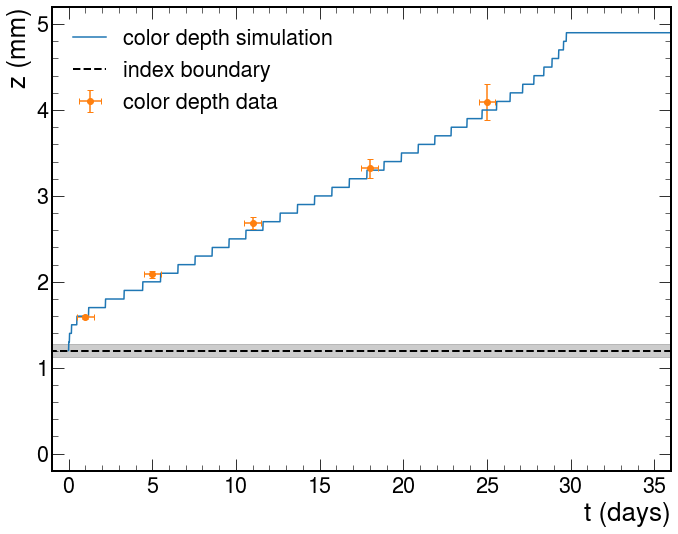

In [6]:
# These parameters will make the simulation match the experimental data
D = 0.1
R = 0.0006
k1 = 0.02
k2 = 0.2

run_sim(D, R, k1, k2)
plot_data_vs_sim(D, R, k1, k2)

## Run a parameter scan
The parameter space can be explored by running the simulation for different values.

In [ ]:
D = 0.1
R_arr = [0.0003, 0.00045, 0.0006]
k1_arr = [0.01, 0.02, 0.03]
k2_arr = [0.05, 0.1, 0.2]
for R, k1, k2 in itertools.product(R_arr, k1_arr, k2_arr):
    run_sim(D, R, k1, k2)